In [1]:
import os
import string
from collections import Counter
from datetime import datetime

import nltk
import pandas as pd
import matplotlib
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.util import ngrams

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Preparing data

In [3]:
original_keywords = ["Picard", "Kirk", "Sulu", "Uhura", "Spock", "McCoy", "Bones", "Scotty", "Chekhov", "Crusher", "Nurse Chapel", "Sarek", "Nero", "Khan", "Data", "Pike", "Star Trek", "Klingon", "Vulcan", "Romulan", "Star fleet", "Starship Enterprise", "Delta Vega", "Earth", "Orion", "Romulan Narada", "Stardate", "Transporter beam", "Beam me up,\? Scotty", "Kobayashi Maru", "Space,\? The Final Frontier", "Energize", "Vulcan Salute", "Prime Directive", "Live long and prosper", "LLAP", "I'm a doctor,\? not a", "KHAAA\+N", "When you eliminate the impossible,\? whatever remains,\? however improbable,\? must be the truth", "Without followers,\? evil cannot spread", "The needs of the many outweigh the needs of the few", "Highly illogical", "to boldly go where no man has gone before", "I'm giving her all she's got,\? Captain", "Nuclear wessels", "Set phasers to stun", "Resistance is futile", "I have been and always shall be your friend"]

In [4]:
print(original_keywords)

['Picard', 'Kirk', 'Sulu', 'Uhura', 'Spock', 'McCoy', 'Bones', 'Scotty', 'Chekhov', 'Crusher', 'Nurse Chapel', 'Sarek', 'Nero', 'Khan', 'Data', 'Pike', 'Star Trek', 'Klingon', 'Vulcan', 'Romulan', 'Star fleet', 'Starship Enterprise', 'Delta Vega', 'Earth', 'Orion', 'Romulan Narada', 'Stardate', 'Transporter beam', 'Beam me up,\\? Scotty', 'Kobayashi Maru', 'Space,\\? The Final Frontier', 'Energize', 'Vulcan Salute', 'Prime Directive', 'Live long and prosper', 'LLAP', "I'm a doctor,\\? not a", 'KHAAA\\+N', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'The needs of the many outweigh the needs of the few', 'Highly illogical', 'to boldly go where no man has gone before', "I'm giving her all she's got,\\? Captain", 'Nuclear wessels', 'Set phasers to stun', 'Resistance is futile', 'I have been and always shall be your friend']


In [5]:
ambiguous_keywords = [
    'Bones',
    'Khan',
    'Data',
    'Earth',
    'Energize',
]

In [6]:
keywords = list(set(original_keywords).difference(ambiguous_keywords))
keywords = [w.replace('\\', '').lower() for w in keywords]
keywords.sort()

In [7]:
print(keywords)

['beam me up,? scotty', 'chekhov', 'crusher', 'delta vega', 'highly illogical', 'i have been and always shall be your friend', "i'm a doctor,? not a", "i'm giving her all she's got,? captain", 'khaaa+n', 'kirk', 'klingon', 'kobayashi maru', 'live long and prosper', 'llap', 'mccoy', 'nero', 'nuclear wessels', 'nurse chapel', 'orion', 'picard', 'pike', 'prime directive', 'resistance is futile', 'romulan', 'romulan narada', 'sarek', 'scotty', 'set phasers to stun', 'space,? the final frontier', 'spock', 'star fleet', 'star trek', 'stardate', 'starship enterprise', 'sulu', 'the needs of the many outweigh the needs of the few', 'to boldly go where no man has gone before', 'transporter beam', 'uhura', 'vulcan', 'vulcan salute', 'when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth', 'without followers,? evil cannot spread']


In [8]:
%%time

dtypes = {
    'author': str,
    'body': str,
    'controversiality': str,
    'created_utc': pd.tslib.Timestamp,
    'distinguished': str,
    'downs': str,
    'gilded': str,
    'id': str,
    'name': str,
    'parent_id': str,
    'score': str,
    'subreddit': str,
    'ups': str,
    'month': pd.tslib.Timestamp,
    'year': pd.tslib.Timestamp,
}

reddit_df = pd.read_csv('reddit.csv', header=0, dtype=dtypes, parse_dates=['created_utc', 'month', 'year'])
reddit_df = reddit_df.fillna('')

CPU times: user 34.5 s, sys: 2.42 s, total: 36.9 s
Wall time: 46.8 s


In [9]:
len(reddit_df)

2669814

In [10]:
reddit_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
0,gschizas,same in greek. my personal peeve: quite a lot ...,0,2007-10-15 15:22:33,,0.0,0,c029c79,t1_c029c79,t1_c029brz,13,programming,13,2007-10-01,2007-01-01
1,[deleted],&gt;they also decided to rig a thermal barrier...,0,2007-10-16 05:11:09,,0.0,0,c029g6h,t1_c029g6h,t3_5ye94,2,programming,2,2007-10-01,2007-01-01
2,johnmudd,&gt; by the time a child born today graduates ...,0,2007-10-16 07:00:36,,0.0,0,c029gfc,t1_c029gfc,t3_5ye9w,1,science,1,2007-10-01,2007-01-01
3,feliniti,nero 8 - bloated waste of money. unless you ha...,0,2007-10-16 07:10:27,,0.0,0,c029gge,t1_c029gge,t3_5yej4,1,reddit.com,1,2007-10-01,2007-01-01
4,masklinn,&gt; i wonder what happens if you started clea...,0,2007-10-16 11:27:15,,0.0,0,c029hiy,t1_c029hiy,t1_c029h3y,3,reddit.com,3,2007-10-01,2007-01-01


# Analyzing data

## Subreddits

In [11]:
reddit_df['subreddit'].nunique()

24076

In [12]:
reddit_df['subreddit'].value_counts()

AdviceAnimals            216848
startrek                 182534
AskReddit                179550
fantasyfootball           92045
movies                    65545
nfl                       62410
Smite                     58973
DaystromInstitute         57314
sto                       44103
funny                     37788
doctorwho                 35282
pics                      35054
scifi                     33434
Planetside                27387
todayilearned             25934
GlobalOffensiveTrade      25360
motorcycles               24585
SquaredCircle             20231
Civcraft                  19555
IAmA                      18502
gaming                    18339
atheism                   18110
grandorder                16730
chicagobulls              16501
videos                    16271
nba                       16193
PercyJacksonRP            15635
CFB                       15368
WTF                       13752
TheDescendantsOfRome      13213
                          ...  
Survival

## Global variables

In [13]:
valid_dates = pd.date_range('2007-10-1', '2016-08-31', freq='MS')

In [14]:
P = 10

## startrek

In [15]:
subreddit = 'startrek'

peaks = ['2009-05-01', '2012-12-01', '2013-05-01', '2016-07-01',]
peaks = list(map(pd.lib.Timestamp, peaks))

title = 'Number of comments on subreddit \'' + subreddit + '\' by month'

In [16]:
%%time

subreddit_df = reddit_df[reddit_df['subreddit'] == subreddit]

CPU times: user 408 ms, sys: 140 ms, total: 548 ms
Wall time: 736 ms


In [17]:
len(subreddit_df)

182534

In [18]:
subreddit_by_month = pd.Series(subreddit_df.groupby('month')['id'].count())
subreddit_by_month.index.name = None

In [19]:
show_dates = [x.strftime('%Y %b') if x in peaks else '' for x in valid_dates]

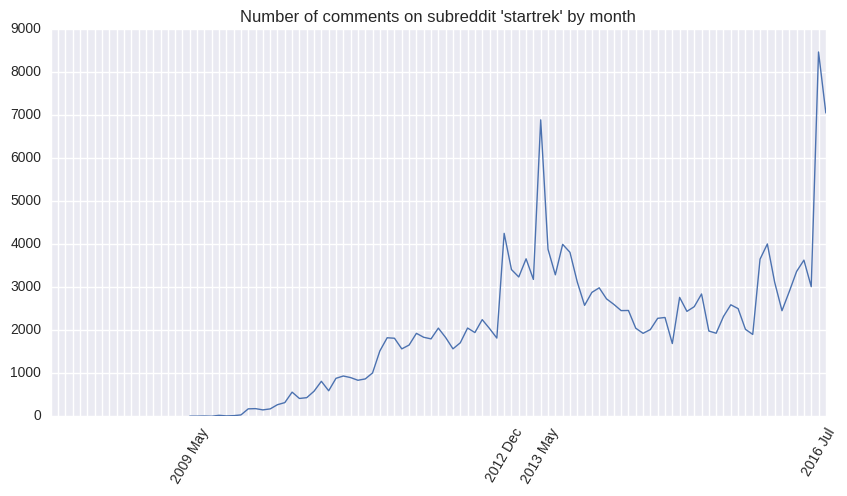

In [20]:
ax = subreddit_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=valid_dates,
    rot=60,
    title=title,
)
ax.set_xticklabels(show_dates);

### Peaks

In [21]:
peaks

[Timestamp('2009-05-01 00:00:00'),
 Timestamp('2012-12-01 00:00:00'),
 Timestamp('2013-05-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2012-12-01

In [22]:
date = '2012-12-01'

In [23]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [24]:
len(subreddit_date_df)

4250

#### Histogram

###### Keywords

In [25]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = subreddit_date_df[subreddit_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [26]:
keywords_counter = Counter(keywords_dict)

In [27]:
keywords_counter.most_common()

[('star trek', 2865),
 ('kirk', 1227),
 ('spock', 860),
 ('picard', 688),
 ('klingon', 502),
 ('vulcan', 392),
 ('romulan', 273),
 ('nero', 158),
 ('scotty', 146),
 ('crusher', 139),
 ('mccoy', 139),
 ('prime directive', 137),
 ('pike', 94),
 ('star fleet', 90),
 ('uhura', 79),
 ('sulu', 77),
 ('live long and prosper', 21),
 ('nurse chapel', 19),
 ('kobayashi maru', 19),
 ('stardate', 17),
 ('delta vega', 17),
 ('sarek', 16),
 ('orion', 11),
 ('khaaa+n', 11),
 ('chekhov', 10),
 ('llap', 9),
 ('resistance is futile', 9),
 ('the needs of the many outweigh the needs of the few', 8),
 ('starship enterprise', 8),
 ('vulcan salute', 7),
 ('highly illogical', 4),
 ('transporter beam', 3),
 ("i'm a doctor,? not a", 2),
 ('beam me up,? scotty', 2),
 ('space,? the final frontier', 1),
 ('without followers,? evil cannot spread', 0),
 ('nuclear wessels', 0),
 ('i have been and always shall be your friend', 0),
 ('set phasers to stun', 0),
 ('to boldly go where no man has gone before', 0),
 ('romul

In [28]:
keywords_sr = pd.Series(keywords_dict)

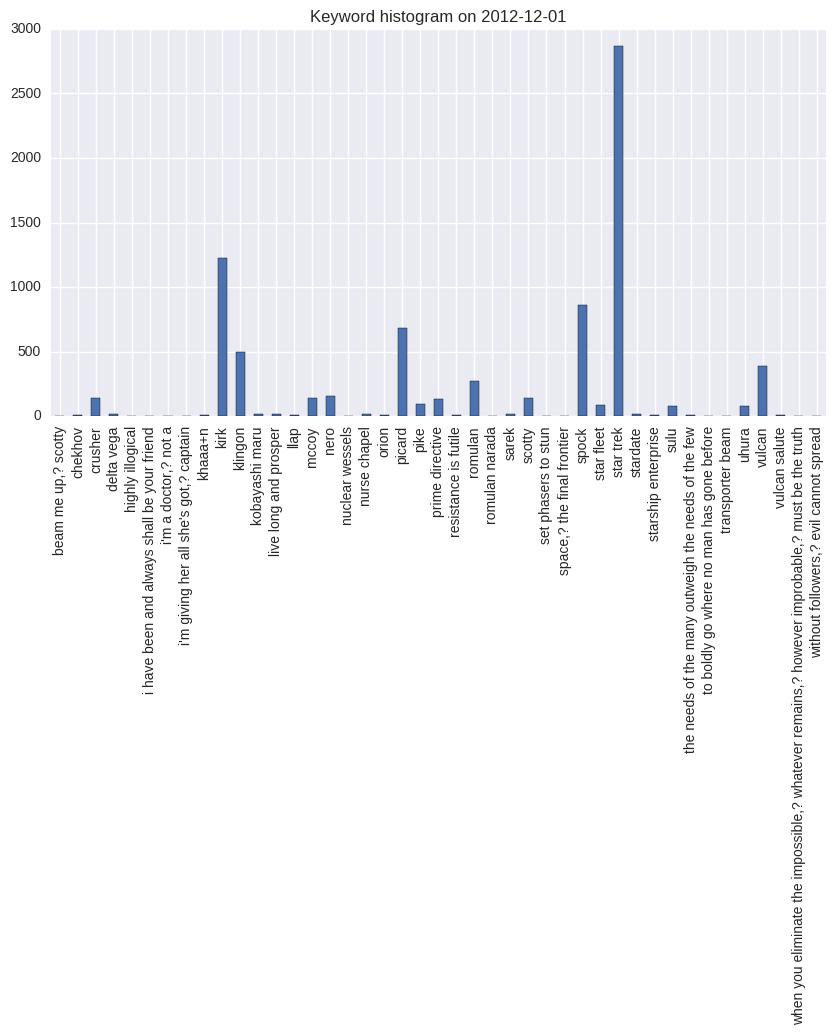

In [29]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [30]:
%%time

text_ = ''
for x in subreddit_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 52.2 s, sys: 3.49 s, total: 55.7 s
Wall time: 56 s


In [31]:
counter_.most_common(20)

[("'s", 3705),
 ('trek', 3294),
 ('star', 3179),
 ("n't", 2636),
 ('``', 1687),
 ("''", 1685),
 ('would', 1680),
 ('like', 1423),
 ('kirk', 1162),
 ('one', 1065),
 ('think', 936),
 ('time', 789),
 ('series', 788),
 ('spock', 768),
 ('really', 756),
 ('movie', 751),
 ('new', 722),
 ('...', 712),
 ('could', 701),
 ('first', 685)]

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [32]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 3.17 s, sys: 4 ms, total: 3.17 s
Wall time: 3.48 s


In [33]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [34]:
sentiment_df.head()

,body,sentiment,subjectivity
0,"not when the motto of all klingon comics is: ""...",0.70,0.60
1,sulu didn't have a japanese accent. he's from...,0.00,0.00
2,"i've always been a fan of the ""everything in l...",0.17,0.35
3,uber star wars fan here.... i would love to ha...,0.62,0.60
4,how could you forget klingon academy,0.00,0.00


In [35]:
sentiment_df['sentiment'].mean()

0.10905434748800666

In [36]:
sentiment_df['subjectivity'].mean()

0.45640362011347496

##### Histogram top positive

In [37]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [38]:
top_df

,body,sentiment,subjectivity
3310,enterprise and voyager are the best star trek ...,1.00,0.30
904,"i was thinking that maybe she is yeoman, janic...",1.00,1.00
3065,dude.. that's gotta be put over on /r/cringe! ...,1.00,1.00
73,i got mine to understand by re-watching star t...,1.00,0.30
4010,it's one of the greatest episodes of star trek...,1.00,1.00
3227,one of the best things about star trek is that...,1.00,0.30
2245,one of the best kirk quotes ever.,1.00,0.30
2490,if we're rating the tng movies solely on their...,1.00,0.30
291,"imho, enterprise season 4 is probably the best...",1.00,0.30
1196,[artemis](http://www.reddit.com/r/artemis) - ...,1.00,0.30


In [39]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 2.26 s, sys: 140 ms, total: 2.4 s
Wall time: 2.4 s


In [40]:
top_counter = Counter(top_list)

In [41]:
top_counter.most_common(20)

[('trek', 240),
 ('star', 238),
 ("'s", 182),
 ('``', 98),
 ("n't", 97),
 ("''", 96),
 ('like', 78),
 ('kirk', 72),
 ('would', 70),
 ('picard', 61),
 ('good', 61),
 ('one', 61),
 ('best', 58),
 ('great', 52),
 ('love', 49),
 ('think', 48),
 ('...', 47),
 ('spock', 43),
 ('series', 41),
 ('also', 37)]

##### Histogram top negative

In [42]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [43]:
top_df

,body,sentiment,subjectivity
3512,christopher lloyd was the worst klingon ever.,-1.00,1.00
3699,&gt; that's literally the worst episode of st...,-1.00,1.00
369,i have to go with pulaski just because i found...,-1.00,1.00
800,but i'll go see it just so i can tell you how ...,-0.90,0.95
3912,wesley crusher was very annoying at times but ...,-0.90,0.95
83,i never thought i'd want to slap someone and b...,-0.90,0.95
395,"correct, the worst of them all is ***cough*** ...",-0.85,0.83
1711,pulaski is a horrible character. and how did y...,-0.85,0.83
1822,i hate to break it to you but argue as you may...,-0.80,0.90
359,"still too soon to tell, but it looks like star...",-0.80,1.00


In [44]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 2.82 s, sys: 172 ms, total: 2.99 s
Wall time: 2.99 s


In [45]:
top_counter = Counter(top_list)

In [46]:
top_counter.most_common(20)

[('trek', 246),
 ('star', 240),
 ("'s", 232),
 ("n't", 147),
 ('``', 112),
 ("''", 108),
 ('kirk', 94),
 ('would', 77),
 ('like', 77),
 ('...', 72),
 ('spock', 57),
 ('one', 54),
 ('think', 48),
 ('even', 47),
 ('bad', 44),
 ('picard', 44),
 ('gt', 42),
 ('time', 39),
 ('http', 38),
 ('really', 36)]

In [47]:
peaks

[Timestamp('2009-05-01 00:00:00'),
 Timestamp('2012-12-01 00:00:00'),
 Timestamp('2013-05-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2013-05-01

In [48]:
date = '2013-05-01'

In [49]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [50]:
len(subreddit_date_df)

6886

#### Histogram

###### Keywords

In [51]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = subreddit_date_df[subreddit_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [52]:
keywords_counter = Counter(keywords_dict)

In [53]:
keywords_counter.most_common()

[('star trek', 4195),
 ('kirk', 2771),
 ('spock', 2389),
 ('klingon', 1212),
 ('picard', 751),
 ('vulcan', 573),
 ('scotty', 457),
 ('mccoy', 308),
 ('nero', 294),
 ('romulan', 260),
 ('uhura', 253),
 ('pike', 250),
 ('sulu', 188),
 ('prime directive', 179),
 ('star fleet', 100),
 ('crusher', 83),
 ('khaaa+n', 58),
 ('sarek', 26),
 ('kobayashi maru', 22),
 ('stardate', 20),
 ('live long and prosper', 20),
 ('chekhov', 18),
 ('orion', 17),
 ('llap', 16),
 ('resistance is futile', 13),
 ('nurse chapel', 12),
 ("i'm a doctor,? not a", 12),
 ('the needs of the many outweigh the needs of the few', 10),
 ('delta vega', 9),
 ('highly illogical', 7),
 ('starship enterprise', 6),
 ('vulcan salute', 5),
 ('nuclear wessels', 4),
 ('space,? the final frontier', 4),
 ('transporter beam', 4),
 ('beam me up,? scotty', 3),
 ('i have been and always shall be your friend', 2),
 ('to boldly go where no man has gone before', 2),
 ('set phasers to stun', 1),
 ('romulan narada', 1),
 ('without followers,? e

In [54]:
keywords_sr = pd.Series(keywords_dict)

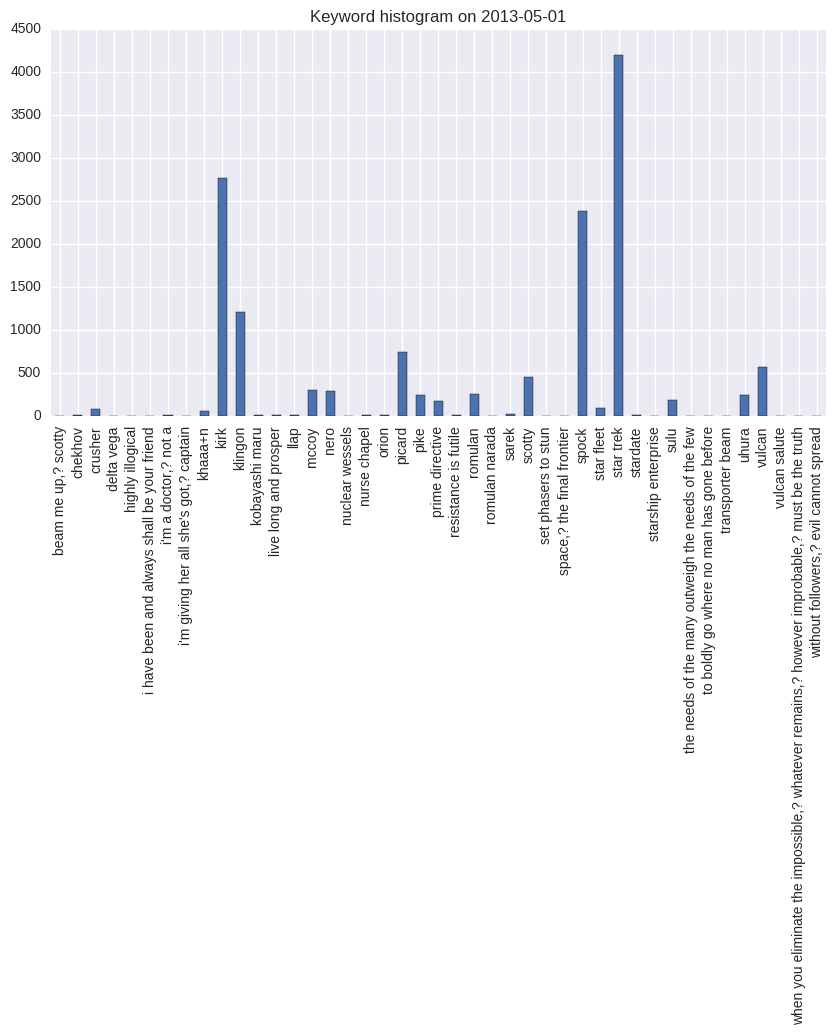

In [55]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [56]:
%%time

text_ = ''
for x in subreddit_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 1min 30s, sys: 6.21 s, total: 1min 36s
Wall time: 1min 42s


In [57]:
counter_.most_common(20)

[("'s", 6384),
 ('trek', 5068),
 ("n't", 4872),
 ('star', 4477),
 ('``', 2830),
 ("''", 2811),
 ('kirk', 2643),
 ('like', 2484),
 ('would', 2463),
 ('spock', 2243),
 ('movie', 2046),
 ('one', 1802),
 ('khan', 1679),
 ('think', 1569),
 ('new', 1481),
 ('...', 1379),
 ('really', 1367),
 ('could', 1216),
 ('first', 1147),
 ('time', 1127)]

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [58]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 12.8 s, sys: 1.02 s, total: 13.8 s
Wall time: 2min 55s


In [59]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [60]:
sentiment_df.head()

,body,sentiment,subjectivity
0,"holy moire, kirk!",0.00,0.00
1,abrams' movie is easily one of the best trek m...,0.61,0.61
2,"guys guys guys, new star trek is good. old (tn...",0.21,0.30
3,"eh, there's some good one-off ones. i really l...",0.40,0.61
4,"i don't think he's ""overacting"", at least as f...",-0.02,0.48


In [61]:
sentiment_df['sentiment'].mean()

0.11140917678554957

In [62]:
sentiment_df['subjectivity'].mean()

0.46197876374164276

##### Histogram top positive

In [63]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [64]:
top_df

,body,sentiment,subjectivity
5585,that's awesome. beginning interior shot is at ...,1.00,1.00
4786,kirks face when he realizes its not spock is p...,1.00,1.00
478,you will make an excellent wife. resistance is...,1.00,1.00
6231,q. his interactions with picard and sisko are ...,1.00,1.00
2416,lol i didn't notice that! - - did they die on...,1.00,0.70
505,"ah, one of the best star trek movies!",1.00,0.30
1088,star trek/bill &amp; ted's crossover. shitty f...,1.00,0.30
509,both times picard gave awesome courtroom speec...,1.00,1.00
4987,"this would be awesome if it said ""picard and d...",1.00,1.00
2681,best star trek movie yet,1.00,0.30


In [65]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 3.96 s, sys: 272 ms, total: 4.23 s
Wall time: 6.74 s


In [66]:
top_counter = Counter(top_list)

In [67]:
top_counter.most_common(20)

[('trek', 388),
 ('star', 359),
 ("'s", 270),
 ("n't", 243),
 ('kirk', 152),
 ("''", 145),
 ('``', 142),
 ('would', 134),
 ('like', 130),
 ('spock', 114),
 ('one', 106),
 ('movie', 104),
 ('great', 101),
 ('...', 98),
 ('good', 94),
 ('best', 93),
 ('think', 88),
 ('love', 81),
 ('khan', 70),
 ('picard', 68)]

##### Histogram top negative

In [68]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [69]:
top_df

,body,sentiment,subjectivity
3207,i didn't like star trek as a kid either. now h...,-1.00,1.00
304,picard at his worst might be every tng movie,-1.00,1.00
1678,nero truly is an evil man.,-1.00,1.00
4187,i heard that cumberbatch was an evil dimension...,-1.00,1.00
3312,camp spock was a terrible casting decision.,-1.00,1.00
4706,"i'm not talking about firefly, i'm talking abo...",-1.00,1.00
6655,i like pine's eyebrows. i like quinto's eyebro...,-1.00,1.00
2701,i would've hated to have been on the internet ...,-0.90,0.70
5963,and the spock tears. i fucking hated that.,-0.90,0.70
1089,are you insane?? he was awful. this film was a...,-0.80,0.75


In [70]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 4.99 s, sys: 364 ms, total: 5.36 s
Wall time: 5.84 s


In [71]:
top_counter = Counter(top_list)

In [72]:
top_counter.most_common(20)

[("'s", 370),
 ('trek', 367),
 ("n't", 337),
 ('star', 330),
 ('``', 204),
 ("''", 197),
 ('kirk', 188),
 ('spock', 186),
 ('like', 150),
 ('movie', 140),
 ('would', 113),
 ('khan', 111),
 ('...', 111),
 ('one', 100),
 ('bad', 87),
 ('enterprise', 83),
 ("'m", 79),
 ('picard', 76),
 ('http', 74),
 ('could', 71)]

In [73]:
peaks

[Timestamp('2009-05-01 00:00:00'),
 Timestamp('2012-12-01 00:00:00'),
 Timestamp('2013-05-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2016-07-01

In [74]:
date = '2016-07-01'

In [75]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [76]:
len(subreddit_date_df)

8462

#### Histogram

###### Keywords

In [77]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = subreddit_date_df[subreddit_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [78]:
keywords_counter = Counter(keywords_dict)

In [79]:
keywords_counter.most_common()

[('star trek', 6190),
 ('kirk', 2216),
 ('spock', 1543),
 ('klingon', 1131),
 ('sulu', 1117),
 ('picard', 908),
 ('vulcan', 531),
 ('romulan', 529),
 ('scotty', 322),
 ('uhura', 315),
 ('mccoy', 268),
 ('nero', 185),
 ('prime directive', 113),
 ('star fleet', 105),
 ('crusher', 102),
 ('pike', 64),
 ('stardate', 60),
 ('chekhov', 35),
 ('llap', 29),
 ('sarek', 29),
 ('orion', 26),
 ('kobayashi maru', 15),
 ('khaaa+n', 15),
 ('live long and prosper', 13),
 ("i'm a doctor,? not a", 12),
 ('starship enterprise', 11),
 ('transporter beam', 10),
 ('nurse chapel', 6),
 ('delta vega', 6),
 ('highly illogical', 5),
 ('to boldly go where no man has gone before', 5),
 ('nuclear wessels', 4),
 ('the needs of the many outweigh the needs of the few', 4),
 ('vulcan salute', 3),
 ("i'm giving her all she's got,? captain", 3),
 ('i have been and always shall be your friend', 2),
 ('space,? the final frontier', 2),
 ('beam me up,? scotty', 2),
 ('without followers,? evil cannot spread', 0),
 ('set phas

In [80]:
keywords_sr = pd.Series(keywords_dict)

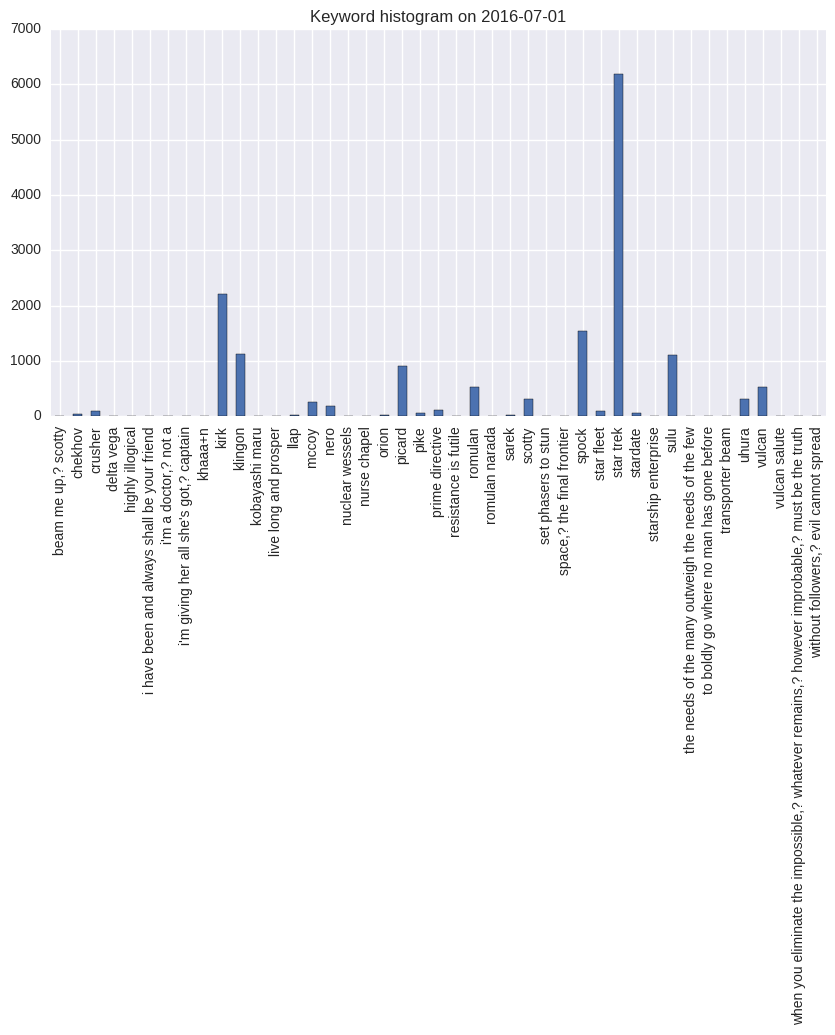

In [81]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [82]:
%%time

text_ = ''
for x in subreddit_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 1min 50s, sys: 7.81 s, total: 1min 58s
Wall time: 2min 41s


In [83]:
counter_.most_common(20)

[("'s", 8692),
 ('trek', 7215),
 ("n't", 6561),
 ('star', 6367),
 ('like', 3568),
 ('``', 3504),
 ("''", 3492),
 ('would', 2814),
 ('think', 2109),
 ('one', 2092),
 ('kirk', 2077),
 ('...', 1894),
 ('movie', 1763),
 ('really', 1679),
 ('people', 1625),
 ('new', 1617),
 ('time', 1604),
 ("'m", 1585),
 ('could', 1538),
 ('even', 1431)]

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [84]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 6.8 s, sys: 32 ms, total: 6.83 s
Wall time: 9.82 s


In [85]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [86]:
sentiment_df.head()

,body,sentiment,subjectivity
0,vulcan women would not wear uncomfortable shoes.,-0.50,1.00
1,then i wouldn't bother. - - i love the origin...,0.15,0.41
2,he's done it for a few lines in the previous m...,-0.03,0.27
3,yes! still a great series! - - it was old wh...,0.15,0.47
4,beam me up scotty.,0.00,0.00


In [87]:
sentiment_df['sentiment'].mean()

0.10954424826620877

In [88]:
sentiment_df['subjectivity'].mean()

0.46977461486056721

##### Histogram top positive

In [89]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [90]:
top_df

,body,sentiment,subjectivity
4310,i hope they do. simon pegg nailed it. the rela...,1.00,0.30
4773,man...i just want to see the movie just for th...,1.00,1.00
4706,it alls fits perfectly within kirk's character,1.00,1.00
827,best tush on star trek until t'pol... even lt....,1.00,0.30
825,"tim russ was the perfect guy to play a vulcan,...",1.00,1.00
1940,try to go to the star trek orchestra if its go...,1.00,1.00
3188,"awesome, don't know how i missed that. is ther...",1.00,1.00
7833,"nah, it was the dauphin. perhaps the greatest...",1.00,1.00
7866,"not going to lie, captain picard was my surrog...",1.00,1.00
5496,i still think that the defiant is one of the b...,1.00,0.30


In [91]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 5.02 s, sys: 356 ms, total: 5.38 s
Wall time: 5.4 s


In [92]:
top_counter = Counter(top_list)

In [93]:
top_counter.most_common(20)

[('trek', 565),
 ('star', 532),
 ("'s", 436),
 ("n't", 300),
 ('like', 187),
 ('good', 173),
 ('``', 168),
 ("''", 168),
 ('would', 158),
 ('kirk', 153),
 ('best', 150),
 ('think', 136),
 ('one', 123),
 ('...', 121),
 ('movie', 120),
 ('great', 113),
 ('really', 96),
 ('spock', 90),
 ('also', 89),
 ("'m", 89)]

##### Histogram top negative

In [94]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [95]:
top_df

,body,sentiment,subjectivity
4997,"oh, star trek fans. always demanding that star...",-1.00,1.00
3617,erf....disheartening. it's not as awful as p...,-1.00,1.00
3684,"i wouldn't say '09 was a terrible movie, but i...",-1.00,1.00
809,"oh god, don't reference clinton's slogan, she ...",-1.00,1.00
6562,"it's insulting to me to call that dreck ""star ...",-1.00,1.00
707,yea jj spock is the worst thing about the st m...,-1.00,1.00
5984,it's the worst star trek ship design i've ever...,-1.00,1.00
7291,but evil spock isn't evil...,-1.00,1.00
616,your lack of respect for the prime directive i...,-1.00,1.00
607,just think of how pissed off evil spock would ...,-1.00,1.00


In [96]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 6.63 s, sys: 456 ms, total: 7.09 s
Wall time: 7.09 s


In [97]:
top_counter = Counter(top_list)

In [98]:
top_counter.most_common(20)

[("'s", 517),
 ('trek', 509),
 ('star', 501),
 ("n't", 428),
 ("''", 233),
 ('``', 232),
 ('like', 230),
 ('kirk', 190),
 ('...', 153),
 ('would', 138),
 ('spock', 129),
 ('one', 126),
 ('think', 121),
 ("'m", 119),
 ('movie', 118),
 ('bad', 114),
 ('time', 106),
 ('ship', 103),
 ('people', 103),
 ('even', 99)]